# Single Cell analysis Exemple with public data

The data comes from : https://pubmed.ncbi.nlm.nih.gov/36216966/

"An anti-influenza combined therapy assessed by single cell RNA-sequencing"

In [1]:
data_path <- "data_dir/GSM5740435_S5.raw_matrix.h5"

In [2]:
library(Seurat)
library(ggplot2)
library(ggExtra)
library(dplyr)
library(rcellmarker)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




We are going to analyse only one sample designated as Mock.

## Data loading and basic preprocessing

In [3]:
scd = Seurat::Read10X_h5(data_path) # single-cell-data

In [4]:
so = CreateSeuratObject(counts = scd, min.cells = 3, min.features = 200) # seurat object

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [5]:
so[["percent.Flu"]] <- PercentageFeatureSet(so, pattern = "^Influ")
so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")

In [6]:
summary(so@meta.data)

         orig.ident      nCount_RNA     nFeature_RNA     percent.Flu      
 SeuratProject:78206   Min.   :  232   Min.   : 200.0   Min.   :0.000000  
                       1st Qu.:  407   1st Qu.: 283.0   1st Qu.:0.000000  
                       Median :  511   Median : 338.0   Median :0.000000  
                       Mean   : 1187   Mean   : 490.8   Mean   :0.001447  
                       3rd Qu.:  578   3rd Qu.: 375.0   3rd Qu.:0.000000  
                       Max.   :91034   Max.   :8835.0   Max.   :3.151618  
   percent.mt     
 Min.   : 0.0000  
 1st Qu.: 0.0000  
 Median : 0.1923  
 Mean   : 1.6224  
 3rd Qu.: 0.4320  
 Max.   :86.4897  

We can see above the distribution of the meain feature, the percentage of reads onto the MT genes, and onto Flu. Flu is globally absent therefore we are in a Mock sample. MT is globally low. MT is important because a high percentage of mt genes is often associated with non-viable cells.

In total there are ~92M reads and 78k cells. However half of cells have less than 500 counts. We could have preferred to target less cells ~5000 but with a higher number of count per cells.

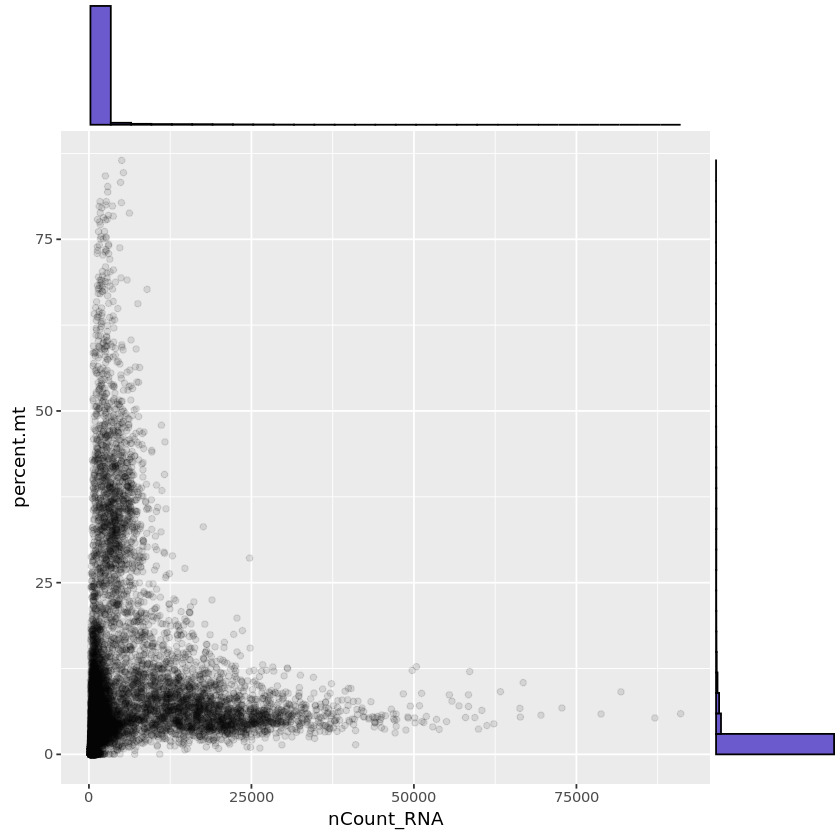

In [7]:
p <- ggplot(so@meta.data, aes(nCount_RNA, percent.mt)) + geom_point(alpha = 0.1)
p2 <- ggMarginal(p, type="histogram", fill = "slateblue")
p2

[1] 2120    5

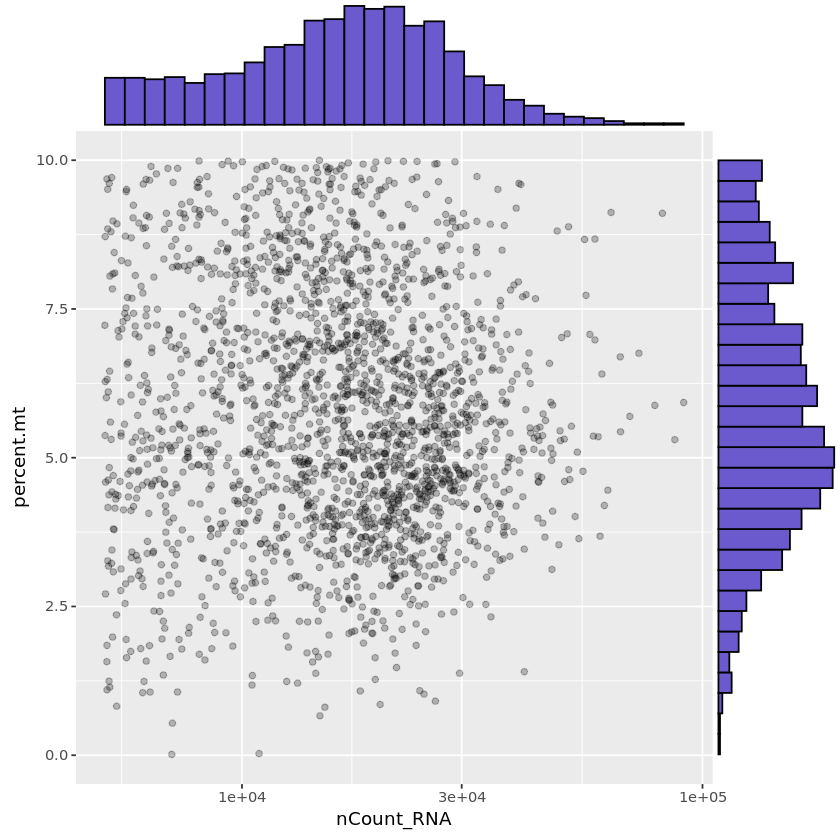

In [8]:
p <- ggplot(subset(so@meta.data, nCount_RNA > 5000 & percent.mt < 10), aes(nCount_RNA, percent.mt)) + 
geom_point(alpha = 0.25) +
scale_x_log10()
p2 <- ggMarginal(p, type="histogram", fill = "slateblue")
p2
dim(subset(so@meta.data, nCount_RNA > 5000 & percent.mt < 10))

In [46]:
summary(so@meta.data)

         orig.ident     nCount_RNA     nFeature_RNA   percent.Flu       
 SeuratProject:2120   Min.   : 5038   Min.   :1417   Min.   :0.0000000  
                      1st Qu.:11092   1st Qu.:3167   1st Qu.:0.0000000  
                      Median :16920   Median :4060   Median :0.0000000  
                      Mean   :18562   Mean   :4074   Mean   :0.0005076  
                      3rd Qu.:23570   3rd Qu.:4874   3rd Qu.:0.0000000  
                      Max.   :91034   Max.   :8835   Max.   :0.0194175  
                                                                        
   percent.mt      RNA_snn_res.0.5 seurat_clusters
 Min.   :0.01421   0:417           0:417          
 1st Qu.:4.31716   1:369           1:369          
 Median :5.58890   2:341           2:341          
 Mean   :5.77441   3:340           3:340          
 3rd Qu.:7.23174   4:329           4:329          
 Max.   :9.99728   5:293           5:293          
                   6: 31           6: 31          

We filtered cells with more than 5000 counts (2120 cells) to exploit in total ~40M counts (half).

In [9]:
so <- subset(so, subset = percent.mt < 10 & nCount_RNA > 5000)


In [10]:
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


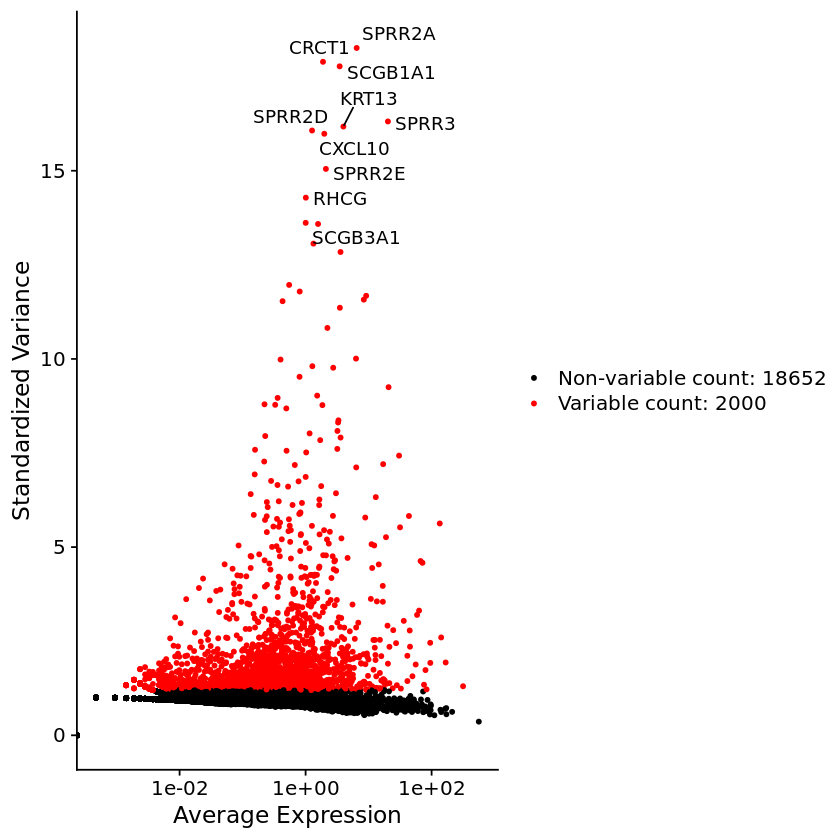

In [11]:
so <- FindVariableFeatures(so, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(so), 10)

#png(filename = "highly_var.png",width = 1000, height = 1000)
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(so)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2
#dev.off()

We will not perform doublet detection as doublets have been filtered out before sequencing.

In [12]:
saveRDS(so, file = "so_S5.rds")

In [13]:
so <- ScaleData(so, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



## Dimention reduction with PCA

In [14]:
so <- RunPCA(so, features = VariableFeatures(object = so))

PC_ 1 
Positive:  S100A2, LDHA, S100A14, S100A16, KRT6A, TUBB, MT1X, ATP1B3, SH3BGRL3, KRT5 
	   FGFBP1, TUBA1C, HSPB1, TUBA4A, FABP5, LDHB, CD44, GJB2, CAV2, SDC1 
	   KRT17, CAV1, CSTA, SERPINF1, H2AFZ, CTSC, TUBA1B, COL17A1, ITGA6, PFN1 
Negative:  CAPS, PIFO, C9orf24, C20orf85, ROPN1L, AGR3, DNALI1, C5orf49, SNTN, RSPH1 
	   TPPP3, C9orf116, CFAP126, FAM81B, CCDC170, RRAD, ZMYND10, LRRIQ1, C9orf135, CAPSL 
	   EFCAB1, RSPH4A, MORN2, C1orf194, TUBA1A, PSENEN, AC007906.2, FAM92B, SAA2, SPA17 
PC_ 2 
Positive:  AGR2, KRT7, AQP5, SLPI, LGALS3, S100P, CD55, CXCL17, ATP1B1, SAT1 
	   ALDH1A1, FAM3D, BPIFB1, CEACAM6, XBP1, LYPD2, PI3, CP, ANXA1, LCN2 
	   ELF3, WFDC2, S100A4, BPIFA1, SERPINB3, SPRR3, MUC1, SERPINB1, CYP2B7P, GLUL 
Negative:  IGFBP7, PLP2, CAV1, S100A10, MIR205HG, SFN, IGFBP2, KRT5, MT2A, COL17A1 
	   EMP3, DST, PTTG1, PDPN, KRT17, TUBA1B, DEK, PFN1, PLTP, CAVIN1 
	   RANBP1, KRT14, TYMS, ITGA6, PCLAF, RAN, HMGB2, MAD2L1, PCNA, STMN1 
PC_ 3 
Positive:  IL1RN, CSTA, KRT16, 

In [15]:
print(so[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  S100A2, LDHA, S100A14, S100A16, KRT6A 
Negative:  CAPS, PIFO, C9orf24, C20orf85, ROPN1L 
PC_ 2 
Positive:  AGR2, KRT7, AQP5, SLPI, LGALS3 
Negative:  IGFBP7, PLP2, CAV1, S100A10, MIR205HG 
PC_ 3 
Positive:  IL1RN, CSTA, KRT16, RHCG, LYPD3 
Negative:  H2AFZ, MKI67, CDK1, RRM2, HMGB2 
PC_ 4 
Positive:  FOS, PFN1, ALDH3A1, LDHB, AKR1C2 
Negative:  CRCT1, TMPRSS11E, SPRR2D, HOPX, APOBEC3A 
PC_ 5 
Positive:  SPRR1B, CSTA, SERPINB3, GLTP, KRT13 
Negative:  LAMB3, IFIT3, IFIT2, ISG15, TNFRSF12A 


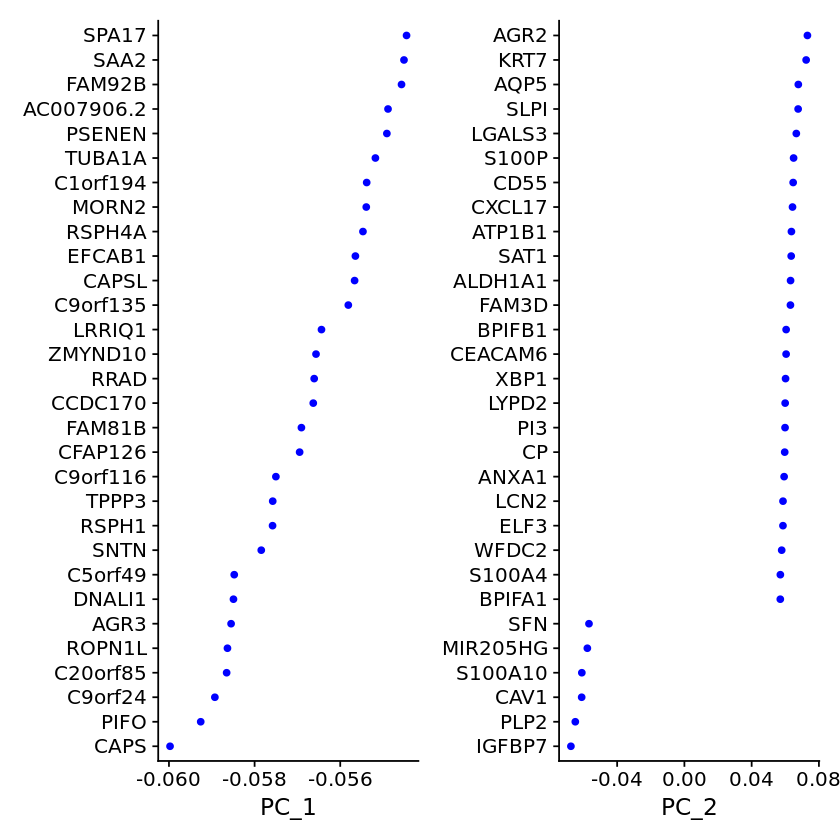

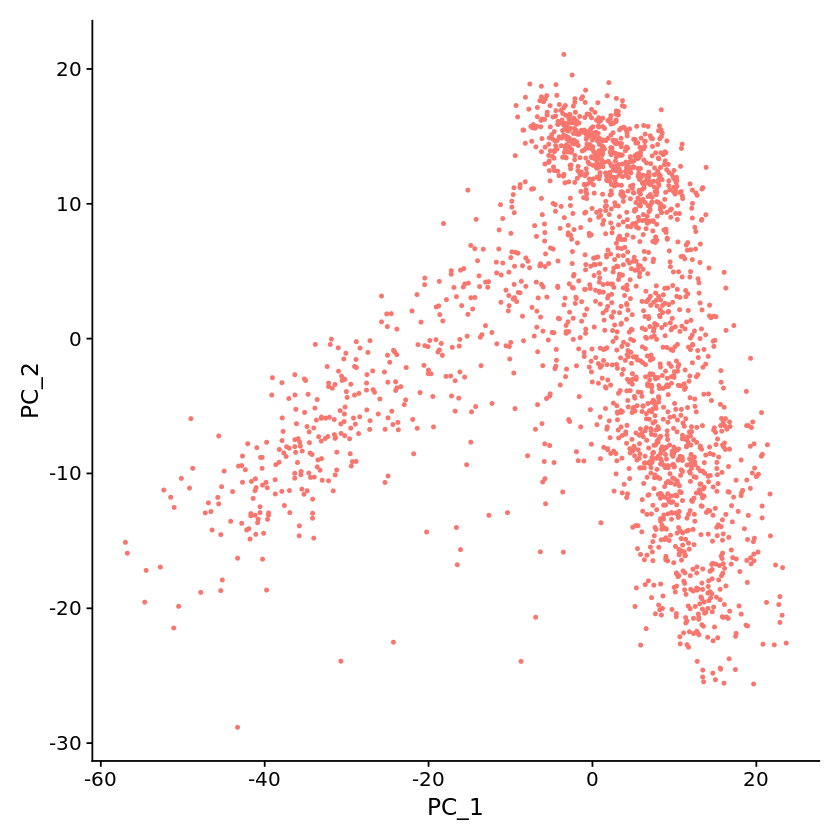

In [16]:
VizDimLoadings(so, dims = 1:2, reduction = "pca")
DimPlot(so, reduction = "pca") + NoLegend()

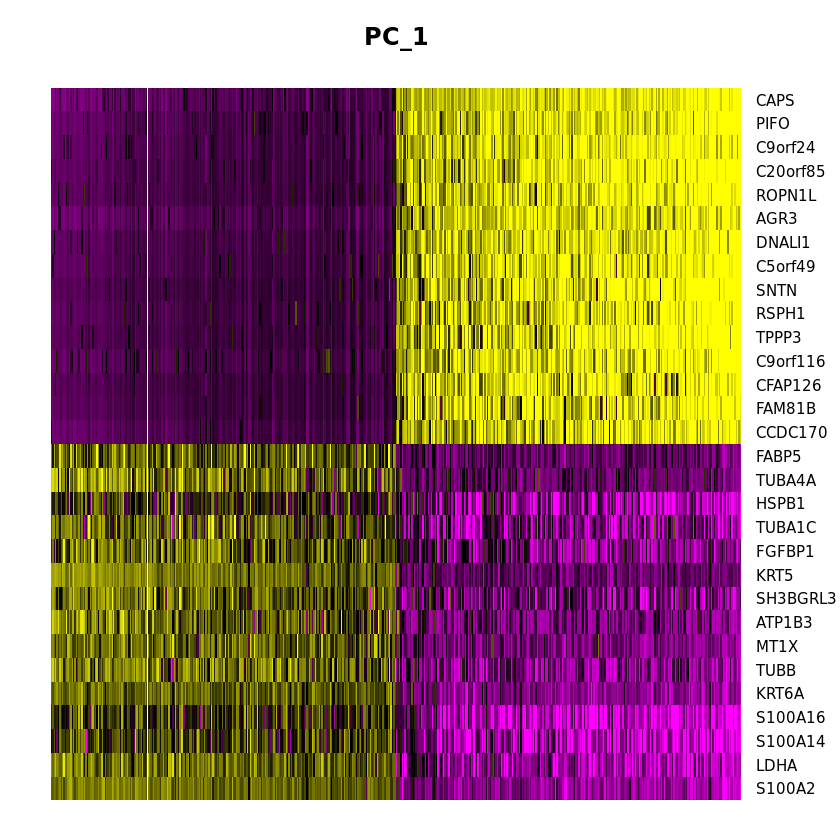

In [17]:
DimHeatmap(so, dims = 1, cells = 500, balanced = TRUE)

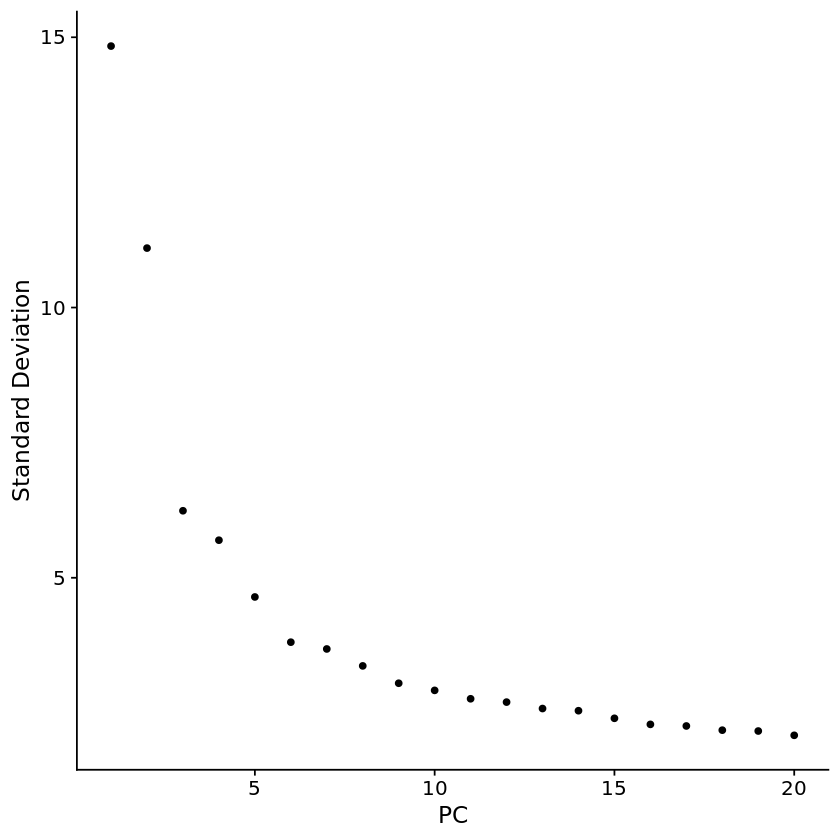

In [18]:
ElbowPlot(so)

We consider from Now that the first 15 dimension from the PCA are enough to perform other analysis inclusing clustering and more adavnced dimentionality reduction (tsne, UMAP)

In [19]:
so <- FindNeighbors(so, dims = 1:15)
so <- FindClusters(so, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2120
Number of edges: 73694

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8608
Number of communities: 7
Elapsed time: 0 seconds


Clutsering found 7 cluster.

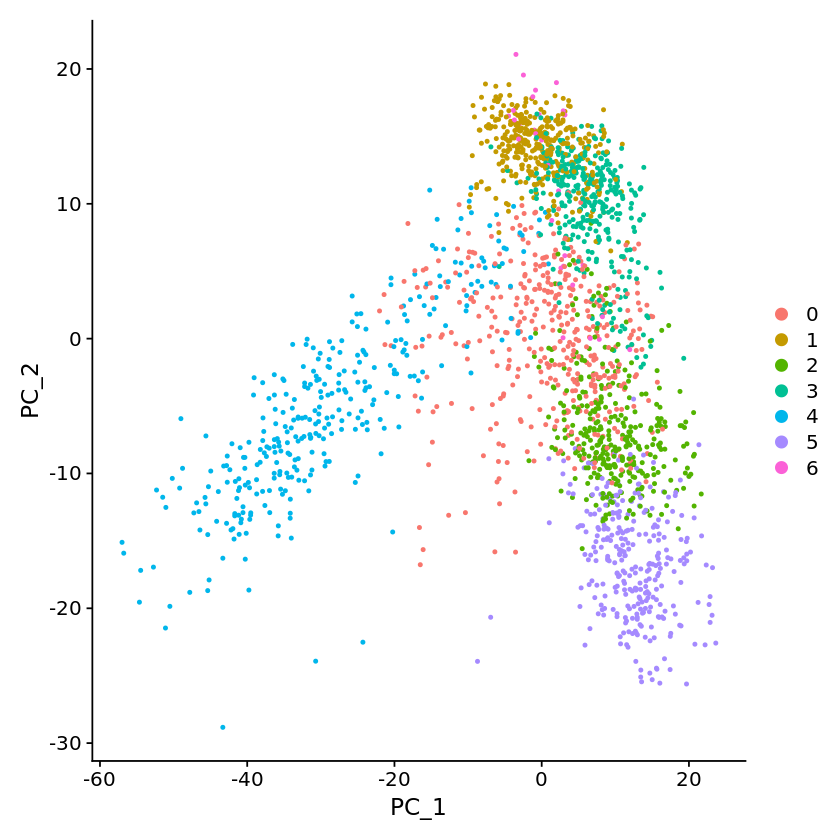

In [20]:
DimPlot(so, reduction = "pca")

Some cluster are visible in PCA but not all. 

In [21]:
so <- RunUMAP(so, dims = 1:15)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
09:49:40 UMAP embedding parameters a = 0.9922 b = 1.112

09:49:40 Read 2120 rows and found 15 numeric columns

09:49:40 Using Annoy for neighbor search, n_neighbors = 30

09:49:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:49:41 Writing NN index file to temp file /tmp/RtmpXX4IJc/filea6ed11ee7869

09:49:41 Searching Annoy index using 1 thread, search_k = 3000

09:49:41 Annoy recall = 100%

09:49:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

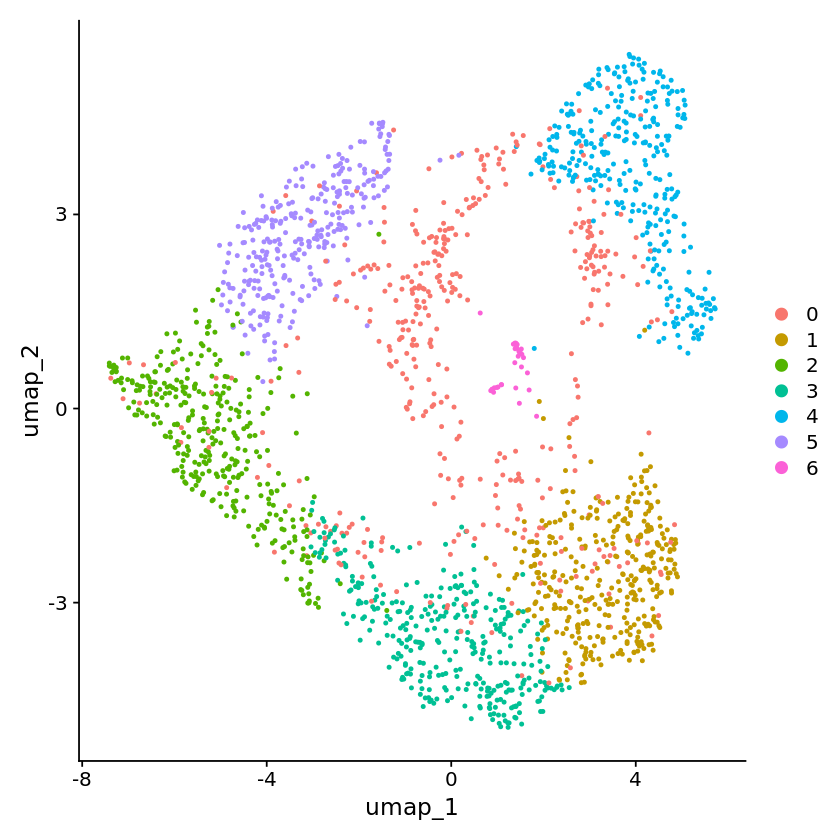

In [22]:
DimPlot(so, reduction = "umap")

In [23]:
so <- RunTSNE(so, dims = 1:15)

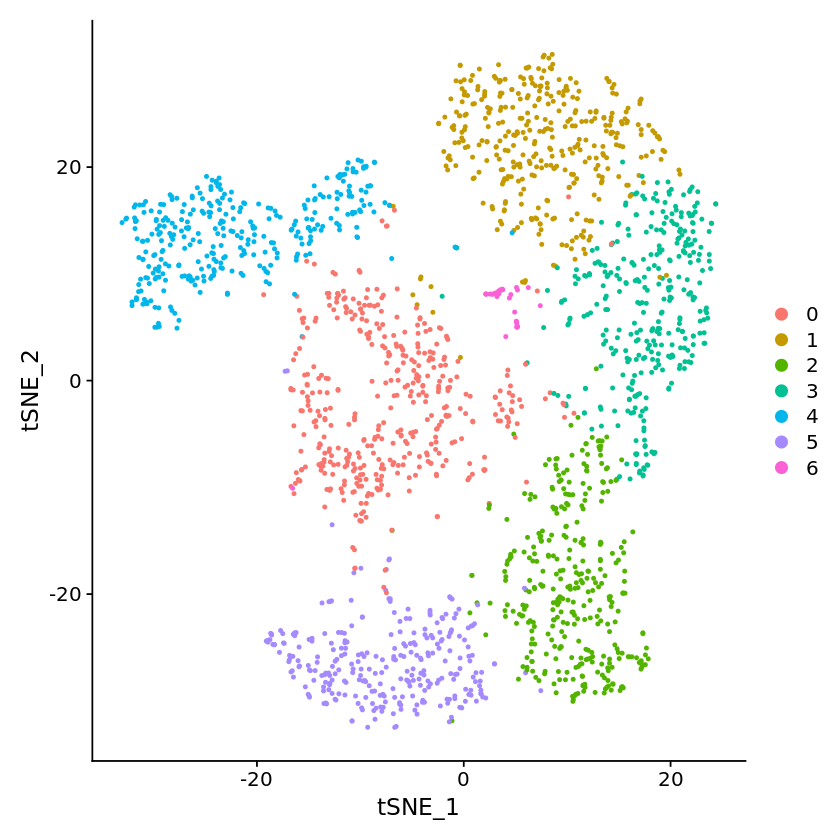

In [24]:
DimPlot(so, reduction = "tsne")

UMAP and T-SNE improves the vusualization of clusters on 2 reduced dimensions.

In [25]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(so, ident.1 = 2)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A2,2.166352e-121,1.452991,1.000,1.000,4.473949e-117
LCN2,6.654806e-117,-3.763674,0.947,0.990,1.374350e-112
MIR205HG,2.947394e-116,1.740638,0.988,0.781,6.086957e-112
KRT5,4.944938e-113,1.670613,1.000,0.938,1.021229e-108
LYPD2,1.510295e-111,-5.105211,0.437,0.883,3.119060e-107


In [26]:
so.markers <- FindAllMarkers(so, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



Warning message in DoHeatmap(so, features = top10$gene):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: AL365356.4, POPDC2, HSP90AB2P, AP000281.1, PAQR7, PHKG1, C1orf56"


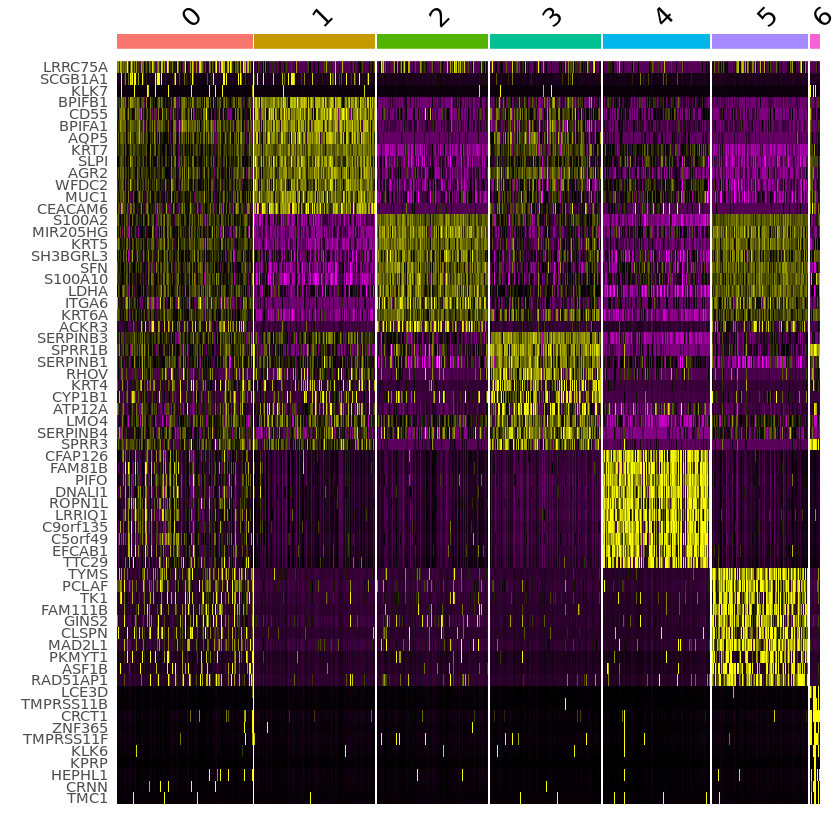

In [27]:
so.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

DoHeatmap(so, features = top10$gene) + NoLegend()

Above the Positive marker of genes for each cluster represented in a heatmap. 

## Cluster annotation

In [28]:
library(celldex)
hpca.se <- HumanPrimaryCellAtlasData()

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, 

In [29]:
library(SingleR)
pred.so <- SingleR(test = as.SingleCellExperiment(so), ref = hpca.se, clusters = Idents(so),
    labels = hpca.se$label.fine, num.threads = 16 )


Attaching package: 'SingleR'


The following objects are masked from 'package:celldex':

    BlueprintEncodeData, DatabaseImmuneCellExpressionData,
    HumanPrimaryCellAtlasData, ImmGenData, MonacoImmuneData,
    MouseRNAseqData, NovershternHematopoieticData




In [30]:
pred.so$labels

[1] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"
[3] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"
[5] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"
[7] "Epithelial_cells:bronchial"

The classification using the database available with singleR are not fine enough below bronchial epithelial cells.

In [31]:
str(so.markers)

'data.frame':	16211 obs. of  7 variables:
 $ p_val     : num  6.64e-53 2.18e-42 6.66e-38 5.83e-37 3.11e-36 ...
 $ avg_log2FC: num  1.425 0.259 0.127 0.508 0.112 ...
 $ pct.1     : num  0.799 0.842 0.998 0.926 0.978 0.916 0.319 0.892 0.777 0.966 ...
 $ pct.2     : num  0.481 0.548 0.933 0.553 0.759 0.696 0.111 0.766 0.5 0.82 ...
 $ p_val_adj : num  1.37e-48 4.50e-38 1.38e-33 1.20e-32 6.43e-32 ...
 $ cluster   : Factor w/ 7 levels "0","1","2","3",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ gene      : chr  "LRRC75A" "MSMB" "MT2A" "PIGR" ...


In [32]:

res <- cellMarker(so.markers,type='seurat',species='human',keytype='SYMBOL',weight=1) #weight for avg_logFC

In [33]:
res

cluster,cellType,Annotated,Significant,Pvalue,Padj,GeneID
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Secretory cell,91,39,1.704322e-41,5.215225e-39,"BPIFB1,BPIFA1,SLPI,WFDC2,CEACAM6,VMO1,CP,RARRES1,LYPD2,STEAP4,CREB3L1,ALDH1A1,SLC6A14,C3,CAPN13,PIGR,MSMB,ANPEP,LGALS9,GABRP,ALDH1A3,ZG16B,SLC34A2,IL1R1,CFB,PLK2,VGLL1,SCGB3A1,MUC5B,DTX4,TGM2,AMOTL2,MUC5AC,SLC26A2,CXCL6,SCGB1A1,PODXL,PPP1R16B,CYFIP2"
1,Goblet cell,109,33,2.689883e-29,4.115520e-27,"BPIFB1,SLPI,AGR2,WFDC2,CEACAM6,VMO1,FER1L6,CEACAM5,MUC4,ERN2,PIGR,SPDEF,MSMB,TSPAN13,DHRS9,GABRP,STARD10,MLPH,FUT6,ST6GALNAC1,SCGB3A1,MUC5B,CLDN10,MUC5AC,SCGB1A1,ACSS2,CAPN8,RNASE1,FCGBP,TSPAN8,PLEKHA6,ENTPD8,OSBPL7"
1,Club cell (Clara cell),14,9,1.570964e-12,1.602383e-10,"BPIFB1,SLPI,WFDC2,LYPD2,MSMB,GABRP,SCGB3A1,MUC5B,SCGB1A1"
2,Basal cell,127,60,1.429667e-71,4.632121e-69,"S100A2,KRT5,SH3BGRL3,SFN,S100A10,ITGA6,KRT6A,ACKR3,COL17A1,CAV1,KRT17,PLP2,SERPINB5,MT1X,FGFBP1,DST,CCND2,TP63,ATP1B3,LAMA3,LGALS7B,PDPN,TIMP1,BCAM,C16orf74,TUBB6,KRT14,ITGB4,DSG3,LGALS7,DSC3,PKP1,SNAI2,AQP3,MMP28,CLCA2,CDH3,LAMB3,SERPINB13,IGFBP6,ANXA8,FAT2,SOX15,FBLN1,WNT10A,GPNMB,DUSP7,ANXA8L1,TNS4,IL20RB,NECTIN1,GM2A,LGALS1,LYPD3,CD109,KRT15,BMP7,KRT6C,LOXL4,NT5E"
2,Astrocyte,492,38,5.451496e-14,8.831423e-12,"ITGA6,MT1X,GJA1,CD44,FGFR3,PDPN,TIMP1,MT2A,PLTP,TNC,SERPINE2,ITGB4,TIMP3,CA12,GJB6,MT1E,DKK3,LGALS1,HTRA1,LRP1,EFEMP1,CD109,APOE,P2RY1,SEMA6A,CDH11,ELN,LHFPL6,BMP7,CXCL14,SPOCK1,MFGE8,RGS20,OLFM2,NT5E,NSG1,GLI3,COL12A1"
2,Fibroblast,174,23,1.277749e-13,1.379969e-11,"WNT4,CD44,PDPN,TIMP1,TNC,KRT14,IGFBP2,ITGB1,CALD1,FBLN1,MYC,DKK3,LRP1,TAGLN,SERPINH1,APOE,SERPINE1,HMGA2,CXCL14,AXL,LTBP2,BMP2,NT5E"
3,Basal cell,127,15,4.021467e-12,6.876708e-10,"SPRR1B,SERPINB1,KRT4,CSTA,GLTP,NRARP,POLR2J3,CLCA4,KRT13,SPRR1A,IVL,SERPINB13,UPK3BL1,KRT6B,LYPD3"
3,Secretory cell,91,11,2.622686e-09,2.242396e-07,"SERPINB3,KRT4,SERPINB4,ALDH1A1,PI3,GABRP,B4GALT5,SLC16A9,CAPN13,CXCL6,SLC4A4"
3,Epithelial cell,254,13,2.637748e-06,1.503516e-04,"SERPINB3,SERPINB4,SPRR3,S100A9,CLDN4,CYP2F1,KRT13,IVL,MMP7,ESRP2,TNIP3,FREM2,DSC2"


CellMarker and PanglaoDB databases gives more precise annotation

## Automatic annotation from a work specific from human airway

https://www.atsjournals.org/doi/full/10.1164/rccm.201911-2199OC

In [34]:
# Test annotation with Easy Cell Type
system("cd data_dir; wget https://www.genomique.info/cellbrowser/HCA/HCA_airway_epithelium/markers.tsv")

In [35]:
ref_markers = read.delim("data_dir/markers.tsv", sep = "\t")
str(ref_markers)

'data.frame':	29000 obs. of  7 variables:
 $ clusters    : chr  "AT1" "AT1" "AT1" "AT1" ...
 $ genes       : chr  "RTKN2" "AGER" "CLDN18" "TNNC1" ...
 $ logFC       : num  7.55 8.69 11.7 6.93 7.55 ...
 $ score       : num  5.48 5.48 5.48 5.48 5.48 ...
 $ pvals       : num  4.33e-08 4.33e-08 4.34e-08 4.34e-08 4.34e-08 ...
 $ pvals_adj   : num  5.4e-06 5.4e-06 5.4e-06 5.4e-06 5.4e-06 ...
 $ grch38_genes: chr  "RTKN2" "AGER" "CLDN18" "TNNC1" ...


In [36]:
ref_markers %>%
    group_by(clusters) %>%
    dplyr::filter(pvals_adj < 0.01) %>%
    ungroup() -> filtered_markers

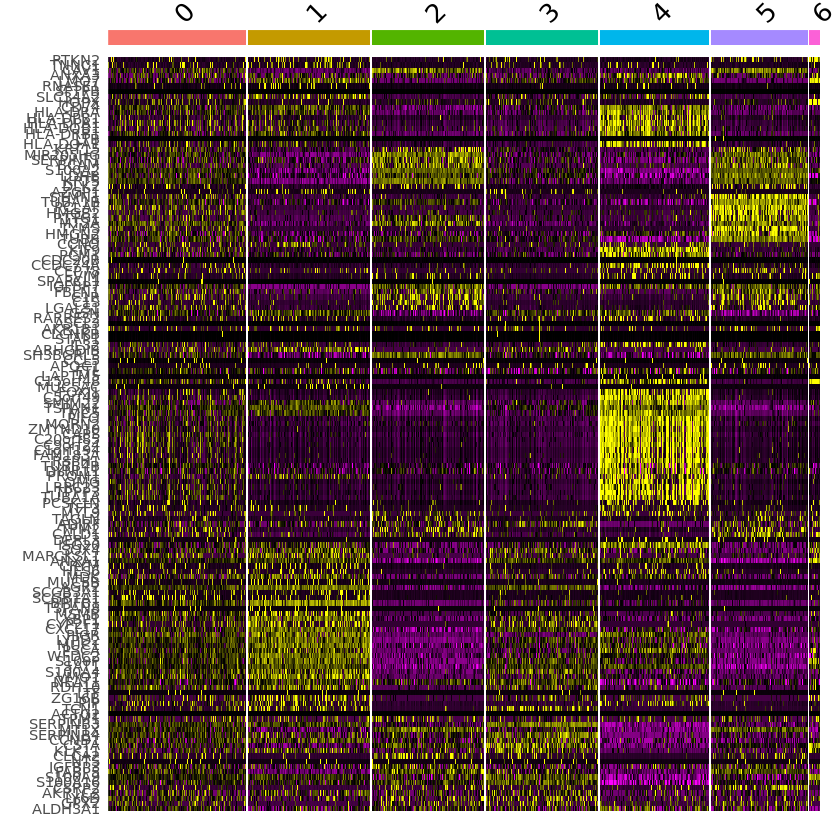

In [37]:
filtered_markers %>%
    group_by(clusters) %>%
    dplyr::filter(logFC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

DoHeatmap(so, features = top10$grch38_genes) + NoLegend()

Above, we just look at the top marker genes from the paper on muculair single cell data per cluster. 

In [42]:
so.markers %>%
    group_by(cluster) %>%
    dplyr::filter(p_val_adj < 0.01) %>%
    ungroup() -> filtered_so.markers

In [43]:
str(filtered_markers)
str(filtered_so.markers)


tibble [18,844 x 7] (S3: tbl_df/tbl/data.frame)
 $ clusters    : chr [1:18844] "AT1" "AT1" "AT1" "AT1" ...
 $ genes       : chr [1:18844] "RTKN2" "AGER" "CLDN18" "TNNC1" ...
 $ logFC       : num [1:18844] 7.55 8.69 11.7 6.93 7.55 ...
 $ score       : num [1:18844] 5.48 5.48 5.48 5.48 5.48 ...
 $ pvals       : num [1:18844] 4.33e-08 4.33e-08 4.34e-08 4.34e-08 4.34e-08 ...
 $ pvals_adj   : num [1:18844] 5.4e-06 5.4e-06 5.4e-06 5.4e-06 5.4e-06 ...
 $ grch38_genes: chr [1:18844] "RTKN2" "AGER" "CLDN18" "TNNC1" ...
tibble [7,533 x 7] (S3: tbl_df/tbl/data.frame)
 $ p_val     : num [1:7533] 6.64e-53 2.18e-42 6.66e-38 5.83e-37 3.11e-36 ...
 $ avg_log2FC: num [1:7533] 1.425 0.259 0.127 0.508 0.112 ...
 $ pct.1     : num [1:7533] 0.799 0.842 0.998 0.926 0.978 0.916 0.319 0.892 0.777 0.966 ...
 $ pct.2     : num [1:7533] 0.481 0.548 0.933 0.553 0.759 0.696 0.111 0.766 0.5 0.82 ...
 $ p_val_adj : num [1:7533] 1.37e-48 4.50e-38 1.38e-33 1.20e-32 6.43e-32 ...
 $ cluster   : Factor w/ 7 levels "0","1

In [44]:
xscore = function(x,y) {
    genes = intersect(names(x), names(y))
    #y[setdiff(names(x), names(y))] = 0
    #x[setdiff(names(y), names(x))] = 0
    if (length(genes) < 5 ) {
        return(list(estimate = 0, p.value = 1))
    }
    res = cor.test(x[genes], y[genes], method="spearman")
    return(res)
}

mark_annot = NULL
for (cluster in unique(filtered_so.markers$cluster)) {
    for (cell_type in unique(filtered_markers$clusters)){
        idx_x <- filtered_so.markers$cluster == cluster
        idx_y <- filtered_markers$clusters == cell_type
        x <- filtered_so.markers$avg_log2FC[idx_x]
        names(x) <- filtered_so.markers$gene[idx_x]
        y = filtered_markers$logFC[idx_y]
        names(y) = filtered_markers$grch38_genes[idx_y]
        res = xscore(x, y)
        tmp_df = data.frame(
            cluster = cluster,
            cell_type = cell_type,
            pval = res$p.value,
            rho = as.numeric(res$estimate)
        )
        if (is.null(mark_annot)) {
            mark_annot = tmp_df
        } else {
            mark_annot <- rbind(mark_annot, tmp_df)
        }
    }
}


I did not find something very already packaged well for automatic annotation from a custom datasets, so I used a BASIC startegy using spearmann correlation between marker LogFC (cell_types vs mucilair cluster). LogFC here is pseudobulk comparison of the cells in the cluster vs others.

In [45]:
mark_annot %>%
    group_by(cluster) %>%
    dplyr::filter(rho > 0 & pval < 0.001) %>%
    dplyr::arrange(-.data$rho) %>%
    slice_head(n = 5) %>%
    ungroup()


cluster,cell_type,pval,rho
<chr>,<chr>,<dbl>,<dbl>
0,Cycling Basal,1.674346e-05,0.6354597
1,Smooth muscle,2.092650e-06,0.8400000
1,Mast cells,4.157855e-06,0.7331378
1,PNEC,2.503016e-08,0.7242857
1,LT/NK,3.536111e-05,0.5961945
1,SMG Goblet,0.000000e+00,0.5699467
2,Smooth muscle,0.000000e+00,0.8018512
2,Pericyte,2.778229e-07,0.7538462
2,B cells,5.359162e-04,0.7481940


Above the Top 5 cluster-cell type potential annotation, with the spearman correlation (rho) and a p.value (not adjusted).